In [1]:
#Imports 
import pip
import glob, os
from sklearn import svm 
import scipy.io as sc
import numpy as np
from HelperFunctions_ import write_dataset_to_file, split_dataset_paths, subFrame, preprocesing_data, combinePictures, combineModels, classesInLabels, combineLabelClasses, lessBands, reshape_sj
from SVM_Desion_Tree import SvmDesionTree, SeperateDataLabels
import sys 
from spectral import *

import tables as tab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import StackingClassifier
import pandas as pd
from sklearn import datasets
import copy
import spectral


In [2]:
#Finding path names 
Mjosa_data = split_dataset_paths("../Datasets/2022_07_11_Mjosa/2022_07_11_Mjosa/", ["he5", "csv", "jpg"])
Andebu_data = split_dataset_paths("../Datasets/2021_07_21_Andebu/2021_07_21_Andebu/", ["he5", "csv", "jpg"])
Telemark_data = split_dataset_paths("../Datasets/2020_06_23_Telemarkskanalen/2020_06_23_Telemarkskanalen/", ["he5", "csv", "jpg"])

samson_data = split_dataset_paths("../Datasets/samson/", ["mat"])
jasper_data = split_dataset_paths("../Datasets/jasper/", ["mat"])



In [3]:
#Amount of dataset should be handled
N_datasets = 4

#Open files 
open_files_array = []
for i in range(N_datasets):
    file = tab.open_file(Mjosa_data["he5"][i])
    open_files_array.append(file.get_node("/HDFEOS/SWATHS/PRS_L1_HCO/")['Data Fields']['VNIR_Cube'][:,5:,:])

#Load the labels 
load_labels_array = []
for i in range(N_datasets):
    file = Mjosa_data["csv"][i]
    load_labels_array.append(np.loadtxt(file, dtype=np.ubyte))

In [4]:
data = open_files_array[0]
labels = load_labels_array[0]
print(len(labels.flatten()))

1000000


In [5]:
samson = sc.loadmat(samson_data["mat"][1])["V"]
samson_gt = sc.loadmat(samson_data["mat"][0])
samson_labels = np.argmax(samson_gt['A'].T.reshape((-1,3)), axis=1)

jasper = sc.loadmat(jasper_data["mat"][1])["Y"]
jasper_gt = sc.loadmat(jasper_data["mat"][0])
jasper_labels = np.argmax(jasper_gt['A'], axis=0)


In [132]:
d, l = subFrame(data, labels, 0, 50, 0, 50)

In [133]:
X, y = preprocesing_data(d, l)

In [134]:
print(classesInLabels(y))

[0 1 2 3 5]


In [250]:
from sklearn.svm import SVC
from HelperFunctions_ import classesInLabels
import numpy as np
import copy

def SeperateDataLabels(data,labels, seperation): 

    train_data = copy.deepcopy(data)
    train_labels = copy.deepcopy(labels)

    #Check the labels and the seperation have the same number of classes or not 
    # Will remove the classes not in the seperation array. 
    
    if(len(seperation) == 2): 

        classesInSeperation = []

        for i in range(len(seperation)): 
            for j in range(len(seperation[i])): 
                if(not(seperation[i][j] in classesInSeperation)): 
                    classesInSeperation.append(seperation[i][j])

        classesInSeperation.sort()
        classesInSeperation = np.array(classesInSeperation)
        cIL = np.array(classesInLabels(labels))

        #Checks if the seperation and the labels have same amount of classes. If not return -1 ????
        if(not(np.array_equal(cIL, classesInSeperation))): 

            for i in range(len(cIL)): 
                if(not(cIL[i] in classesInSeperation)):
                    train_data = train_data[train_labels != cIL[i]]
                    train_labels = train_labels[train_labels != cIL[i]]

        for i in range(len(seperation)): 
            for j in range(len(seperation[i])):
                if(seperation[i][j] != min(seperation[i])):
                    
                    train_labels[train_labels == seperation[i][j]] = min(seperation[i])
        
        return train_data, train_labels
        
    else: 
        print("The seperation needs to be 2 in length. For 1v1 classification")
        return -1



def BranchDataLabels(data, labels, tree_branches): 

    """
    Takes in data and labes for the SVM Desion Tree. 
    Makes the labels for every branch 1v1 classes. 

    """

    if(len(tree_branches) > 0): 
        if(len(tree_branches[0]) == 2): 

            #Seperating the classes on the first branch of the data and the labels.
            data_and_labels_branches = {0 : SeperateDataLabels(data, labels, tree_branches[0])}
            
            for i in range(1,len(tree_branches)): 
                data_and_labels = []
                for j in range(len(tree_branches[i])): 
                    if(len(tree_branches[i][j]) == 2):
                            data_and_labels.append(SeperateDataLabels(data,labels,tree_branches[i][j]))
                    else: 
                        data_and_labels.append([])
                data_and_labels_branches[i] = data_and_labels

            return data_and_labels_branches
        
        else: 
            return -1


def SvmBranchModelTrain(data_and_labels_branches): 

    svm_branch_models = {}

    svm = SVC()
    train_data, train_labels = data_and_labels_branches[0]
    svm.fit(train_data, train_labels)
    svm_branch_models[0] = svm

    for i in range(1,len(data_and_labels_branches)): 
        svm_models = []
        for j in range(len(data_and_labels_branches[i])): 
            if(len(data_and_labels_branches[i][j]) == 2): 
                train_data, train_labels = data_and_labels_branches[i][j]
                svm = SVC()
                svm.fit(train_data, train_labels)
                svm_models.append(svm)
            else: 
                svm_models.append(False)
        svm_branch_models[i] = svm_models

    return svm_branch_models


def SvmBranchModelTrainDefined(data_and_labels_branches, svm_branch_models): 

    svm_branch_models_ = {}

    svm = svm_branch_models[0]
    train_data, train_labels = data_and_labels_branches[0]
    svm.fit(train_data, train_labels)
    svm_branch_models_[0] = svm

    for i in range(1,len(data_and_labels_branches)): 
        svm_models = []
        for j in range(len(data_and_labels_branches[i])): 
            if(len(data_and_labels_branches[i][j]) == 2): 
                train_data, train_labels = data_and_labels_branches[i][j]
                svm = copy.deepcopy(svm_branch_models[i][j]) 
                svm.fit(train_data, train_labels)
                svm_models.append(svm)
            else: 
                svm_models.append(False)
        svm_branch_models_[i] = svm_models

    return svm_branch_models_


def SvmBranchModelPredict(data_and_labels_branches, svm_branch_models): 
    predicted_branch_labels = {}

    svm = svm_branch_models[0]
    train_data, train_labels = data_and_labels_branches[0]
    yout = svm.predict(train_data)
    predicted_branch_labels[0] = yout

    for i in range(1,len(data_and_labels_branches)): 
        predicted_labels = []
        for j in range(len(data_and_labels_branches[i])): 
            if(len(data_and_labels_branches[i][j]) == 2): 
                train_data, train_labels = data_and_labels_branches[i][j]
                svm = svm_branch_models[i][j]
                yout = svm.predict(train_data)
                predicted_labels.append(yout)
            else: 
                predicted_labels.append([])
        predicted_branch_labels[i] = predicted_labels

    return predicted_branch_labels

def combineLabels(predicted_labels, tree_branch): 

    pl = copy.deepcopy(predicted_labels)
    """
    Combine the result from the desion tree. Should be automated. 
    """
    #if(len(pl) == len(tree_branch)): 
    for i in range(len(pl)-2,0,-1): 
        for j in range(len(pl[i])): 
            for k in range(len(tree_branch[i][j])):
                for l in range(len(tree_branch[i][j][k])): 
                    if(tree_branch[i+1][j]):
                        try: 
                            if(min(tree_branch[i][j][k]) in tree_branch[i+1][j][l]):
                                print("Fisken print")
                                yout = pl[i][j] 
                                yout_sub_class = pl[i+1][j]

                                class_diff = np.abs(len(yout[yout == min(tree_branch[i][j][k])]) - len(yout_sub_class))
                                for x in range(len(yout)): 
                                    if(yout[x] == min(tree_branch[i][j][k])):
                                        if(class_diff < len(yout_sub_class)):
                                            yout[x] = yout_sub_class[class_diff] 
                                            class_diff += 1
                                pl[i][j] = yout
                                
                        except: 
                            None 
    

    #Collecting the labels from the second branch layer to the first layer. ¨
    #Cobime the two second layers to the final labeling. 
    
    yout_sub_1 = pl[1][0]
    yout_sub_2 = pl[1][1]

    print(classesInLabels(yout_sub_1)) 
    #print(classesInLabels(yout_sub_2))

    yout = pl[0]

    if(yout_sub_1 == []): 
        class_diff = np.abs(len(yout[yout == min(tree_branch[0][1])]) - len(yout_sub_2))
        for x in range(len(yout)): 
            if(yout[x] in tree_branch[0][1]):
                if(class_diff < len(yout_sub_2)):
                    yout[x] = yout_sub_2[class_diff] 
                    class_diff += 1
        print(class_diff)

    elif(yout_sub_2 == []): 
        class_diff = np.abs(len(yout[yout == min(tree_branch[0][0])]) - len(yout_sub_1))
        for x in range(len(yout)): 
            if(yout[x] in tree_branch[0][0]):
                if(class_diff < len(yout_sub_1)):
                    yout[x] = yout_sub_1[class_diff] 
                    class_diff += 1
        print(class_diff)

    else:
        count_sub_1 = 0 
        count_sub_2 = 0 
        for x in range(len(yout)): 
            if(yout[x] in tree_branch[0][0]):
                if(count_sub_1 < len(yout_sub_1)):
                    yout[x] = yout_sub_1[count_sub_1] 
                    count_sub_1 += 1
            if(yout[x] in tree_branch[0][1]):
                if(count_sub_2 < len(yout_sub_1)): 
                    yout[x] = yout_sub_1[count_sub_2] 
                    count_sub_2 += 1

        print(count_sub_1)
        print(count_sub_2)

    return yout

def SvmDesionTree(data, labels, tree_branches, svm_branch_models = {}):
    """
    Every branch in the SVM Desion Tree is aimed to be 1v1 and 1vRest classification. 
    """
    #Seperating the data and labels to different sub classes

    data_and_labels_branches = BranchDataLabels(data, labels, tree_branches)

    #Trains a svm model for each branch from the 
    #If svm_branch_models defined, if not defined every branch have just regular SVC() 

    

    if(len(svm_branch_models) > 0): 
        svm_branch_models = SvmBranchModelTrainDefined(data_and_labels_branches, svm_branch_models)
    else: 
        svm_branch_models = SvmBranchModelTrain(data_and_labels_branches)

    predicted_branch_labels = SvmBranchModelPredict(data_and_labels_branches, svm_branch_models)

    predicted_label = combineLabels(predicted_branch_labels, tree_branches)

    return predicted_label

In [256]:
# 1) Spruce, 2) Pine , 3) Decidous (leaf), 4) Water, 5) Clouds, and 0) other
#tb =   {0 : [[1,2,3], [0,5]], 1 : [[[1,2], [3]],[[0],[5]]] , 2 : [[[1],[2]], []]}
tb = {0 : [[1,2,3,5], [0]], 1 : [[[5], [1,2,3]], []], 2 : [[[3], [1,2]],[]], 3 : [[[1], [2]], []]}


svm = SVC(kernel="linear", C=1000)
svm1 = SVC(kernel="linear", C=1000)
svm2 = SVC(kernel="linear", C=1000)
svm3 = SVC(kernel="linear", C=1000)

sbm = {0: svm, 1 : [svm1,False], 2 : [svm2, False], 3: [svm, svm]}

dl = SvmDesionTree(X,y,tb, sbm)

Fisken print
Fisken print
[1 2 3 5]
1814


C:\Users\jonas\AppData\Local\Temp\ipykernel_32108\1658235883.py:189: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):


In [239]:

l = combineLabels(dl, tb)

print(l)

Fisken print
Fisken print
[1 2 3 5]
1814
[1 2 3 ... 3 1 1]


C:\Users\jonas\AppData\Local\Temp\ipykernel_32108\457109984.py:189: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):


In [240]:
classesInLabels(l)

array([1, 2, 3, 5], dtype=uint8)

In [212]:
print([min([1,2])] in [[1],[2]])

True


In [251]:
# 1) Spruce, 2) Pine , 3) Decidous (leaf), 4) Water, 5) Clouds, and 0) other
#tb =   {0 : [[1,2,3], [0,5]], 1 : [[[1,2], [3]],[[0],[5]]] , 2 : [[[1],[2]], []]}
tb = {0 : [[1,2,3,5], [0]], 1 : [[[5], [1,2,3]], []], 2 : [[[3], [1,2]],[]], 3 : [[[1], [2]], []]}


svm = SVC(kernel="linear", C=1000)
svm1 = SVC(kernel="linear", C=1000)
svm2 = SVC(kernel="linear", C=1000)
svm3 = SVC(kernel="linear", C=1000)

sbm = {0: svm, 1 : [svm1,False], 2 : [svm2, False], 3: [svm3, False]}

pl = SvmDesionTree(X,y,tb, sbm)




Fisken print
Fisken print
[1 2 3 5]
1814


C:\Users\jonas\AppData\Local\Temp\ipykernel_32108\1658235883.py:189: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):


In [252]:
print(pl)

[1 5 0 ... 1 0 0]


0.6008


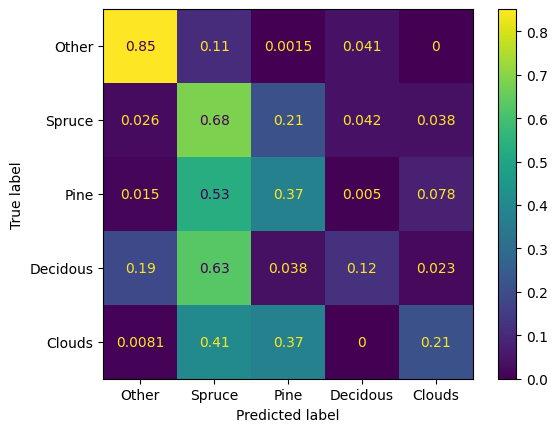

In [253]:
print((pl == y).sum()/len(y))


name_classes = ["Other", "Spruce", "Pine", "Decidous", "Clouds"]


cm = confusion_matrix(y,pl, normalize="true") 
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=name_classes)
cmd_obj.plot()

In [257]:
print(classesInLabels(pl))

[0 1 2 3 5]


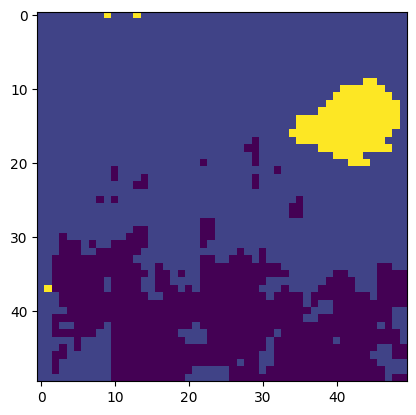

In [139]:
plt.imshow(pl.reshape((50,50)))

In [13]:
new_new_samson = reshape_sj(samson)

X = new_new_samson.transpose(0,2,1).reshape((-1,156))
X = preprocessing.scale(X, axis=0)
print(len(X))

y = samson_labels.flatten()

9025


In [70]:
tb = {0: [[1],[0,2]], 1: [[],[[0],[2]]]}

sbm = {0: SVC(kernel="linear", C=1000), 1 : [False,SVC(kernel="linear", C=1000)]}

pl = SvmDesionTree(X,y,tb, sbm)


print((pl == y).sum()/len(y))

#1 Road, 2# Soil, #3, Water, #4 Three

name_classes = ["Water", "Tree", "Soil"]


cm = confusion_matrix(y,pl, normalize="true") 
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=name_classes)
cmd_obj.plot()

0.0


ValueError: Found input variables with inconsistent numbers of samples: [2500, 2]

In [15]:
# split samson into train test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.999, random_state=1)

In [16]:
new_jasper = reshape_sj(jasper)

X = new_jasper.transpose(0,2,1).reshape((-1,198))
X = preprocessing.scale(X, axis=0)
print(len(X))

y = jasper_labels.flatten()


10000


[0 2 3]
[]
6674
1.0


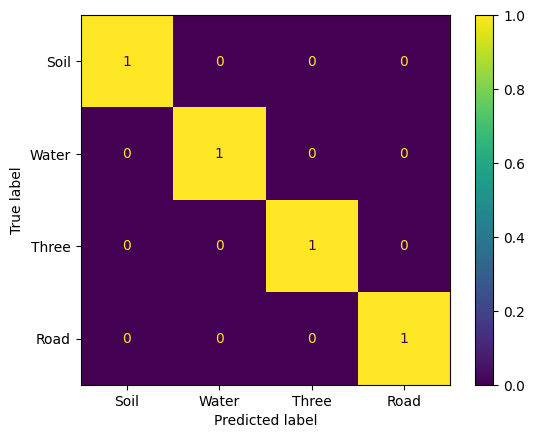

In [17]:
tb = {0: [[0,2,3],[1]], 1: [[[3],[0,2]], []], 2 : [[[0],[2]], []]}

sbm = {0: SVC(kernel="rbf", C=100000), 1 : [SVC(kernel="rbf", C=100000),False], 2: [SVC(kernel="rbf", C=10000), False]}

pl = SvmDesionTree(X,y,tb, sbm)


print((pl == y).sum()/len(y))

#1 Road, 2# Soil, #3, Water, #4 Three

name_classes = ["Soil", "Water", "Three", "Road"]


cm = confusion_matrix(y,pl, normalize="true") 
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=name_classes)
cmd_obj.plot()

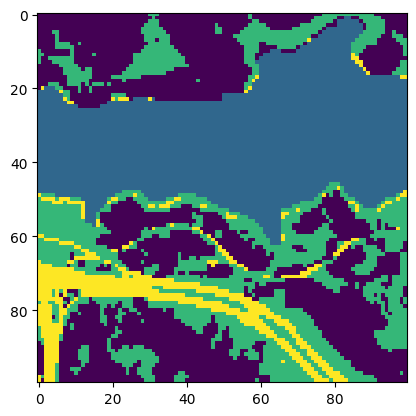

In [18]:
plt.imshow(pl.reshape((100,100)))